## Regresión logistica con bootstrap y validación cruzada

Considerar la información de la **base de datos *iris*** que viene precargada en R. Este dataset contiene $150$ observaciones de la planta iris con $5$ variables cada una: largo y ancho del sépalo, largo y ancho del pétalo, y tipo de especie de iris (*setosa*, *versicolor*, *virginica*). Se os pide lo siguiente:

1. Cargar el dataset y eliminar las observaciones que corresponden a la especie *virginica* para quedaros solamente con dos clases de plantas. Realizar una presentación detallada de la base de datos que vais a analizar tras realizar dicho proceso de filtrado.
2. Dividir el conjunto de datos en dos partes: $80\%$ para entrenamiento y $20\%$ para test. Verificar en ambos casos si las clases están balanceadas tanto en el conjunto de entrenamiento como en el de test, mostrando la cantidad de instancias por clase en ambos conjuntos. ¿Por qué dividimos el conjunto de datos en dos subconjuntos de train y test? Justificar la respuesta.
3. Entrenar un modelo de regresión logística utilizando la técnica de bootstrap con `number=1000`. Explicar paso a paso el procedimiento e interpretar los resultados obtenidos de las salidas del modelo.
4. Entrenar un modelo de regresión logística utilizando la técnica de validación cruzada $k$-fold con `k=10`. Explicar el procedimiento e interpretar los resultados obtenidos de las salidas del modelo.
5. Evaluar y comparar en el conjunto de prueba ambos modelos entrenados utilizando las métricas adecuadas como la precisión, el AUC-ROC, etc. Enumerarlas y describirlas con vuestras propias palabras. ¿Para qué sirven cada una de ellas? Justificar los resultados obtenidos.

<div style="background-color:#5DADE2"><b>Apartado 1</b></div>

In [ ]:
# Cargamos la base de datos iris (viene precargada en R)
data(iris)

# Eliminamos las observaciones correspondientes a la especie virginica
zdata <- subset(iris, Species != "virginica")

# Comprobamos dimensiones y estructura
dim(wdata)
str(wdata)



[1] 51  2

'data.frame':	51 obs. of  2 variables:
 $ obama  : num  38.4 40.8 44.6 36.9 60.2 ...
 $ mujeres: num  51.5 48 50.3 50.9 50.3 49.9 51.3 51.6 52.8 51.1 ...


In [ ]:
# Comprobamos si existen datos NAs para en caso afirmativo, eliminarlos y que no nos den problemas
wdata=na.omit(zdata)
# Podemos comprobar como NO existen datos missing
nrow(zdata) # Base de datos inicial
nrow(wdata) # Base de datos tras el na.omit

[1] 100

[1] 100

como se aprecia no hay datos faltantes

In [ ]:
str(zdata)

'data.frame':	100 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [ ]:
# Realizamos el análisis exploratorio de las variables utilizadas
summary(wdata)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.000   1st Qu.:2.800   1st Qu.:1.500   1st Qu.:0.200  
 Median :5.400   Median :3.050   Median :2.450   Median :0.800  
 Mean   :5.471   Mean   :3.099   Mean   :2.861   Mean   :0.786  
 3rd Qu.:5.900   3rd Qu.:3.400   3rd Qu.:4.325   3rd Qu.:1.300  
 Max.   :7.000   Max.   :4.400   Max.   :5.100   Max.   :1.800  
       Species  
 setosa    :50  
 versicolor:50  
 virginica : 0  
                
                
                

In [ ]:
numeric_vars <- wdata[, sapply(wdata, is.numeric)]
# Cargar librería necesaria para kurtosis
if(!require(moments, quietly = TRUE)){
  install.packages("moments", repos = "https://cloud.r-project.org")
  library(moments)
}

# Desviación estándar de todas las variables numéricas
sapply(numeric_vars, sd, na.rm = TRUE)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
   0.6416983    0.4787389    1.4495485    0.5651531

In [ ]:
# Curtosis de todas las variables numéricas
sapply(numeric_vars, kurtosis, na.rm = TRUE)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
    2.435316     2.838020     1.196591     1.284684

In [ ]:
table(wdata$Species)


    setosa versicolor  virginica 
        50         50          0 

**<u>Interpretación resultados</u>.-**

Tras eliminar la especie *virginica*, la base de datos analizada queda compuesta por **100 observaciones**, correspondientes a las especies **setosa** y **versicolor**, con **50 flores por especie**, lo que configura un conjunto **perfectamente balanceado** desde el punto de vista de clasificación binaria.

Las **cuatro variables cuantitativas** presentan los siguientes comportamientos:

- **Sepal.Length** oscila entre 4.3 y 7.0 cm, con una media de 5.47 y mediana de 5.4. La desviación estándar (≈ 0.64) indica una **variabilidad moderada**, y su curtosis (~ 2.44) sugiere una distribución cercana a la normal, sin colas extremas.

- **Sepal.Width** presenta valores entre 2.0 y 4.4 cm, con media 3.10 y mediana 3.05. Su desviación estándar (≈ 0.48) es menor que la del largo del sépalo, indicando **menor dispersión relativa**. La curtosis (~ 2.84) refuerza la idea de una distribución relativamente concentrada.

- **Petal.Length** muestra un rango amplio (1.0–5.1 cm), con media 2.86 y mediana 2.45. La desviación estándar elevada (≈ 1.45) refleja una **alta variabilidad**, coherente con la fuerte diferencia morfológica entre *setosa* (pétalos cortos) y *versicolor* (pétalos notablemente más largos). Su curtosis (~ 1.20) indica una distribución más aplanada.

- **Petal.Width** varía entre 0.1 y 1.8 cm, con media 0.79 y mediana 0.8. La desviación estándar (≈ 0.57) confirma nuevamente una **dispersión considerable**, asociada a la diferenciación clara entre especies. La curtosis (~ 1.28) apunta a una distribución sin valores extremos.

La variable **Species** actúa como **variable respuesta categórica binaria**, sin observaciones de *virginica*, lo que la hace especialmente adecuada para aplicar y comparar **modelos de clasificación supervisada**.  

En conjunto, los estadísticos descriptivos evidencian que las **variables asociadas al pétalo (longitud y anchura)** presentan una mayor capacidad discriminante entre *setosa* y *versicolor*, mientras que las variables del sépalo muestran solapamientos más importantes. Esto convierte a esta versión filtrada del dataset *iris* en un escenario clásico y apropiado para estudiar técnicas de clasificación y separación entre clases.


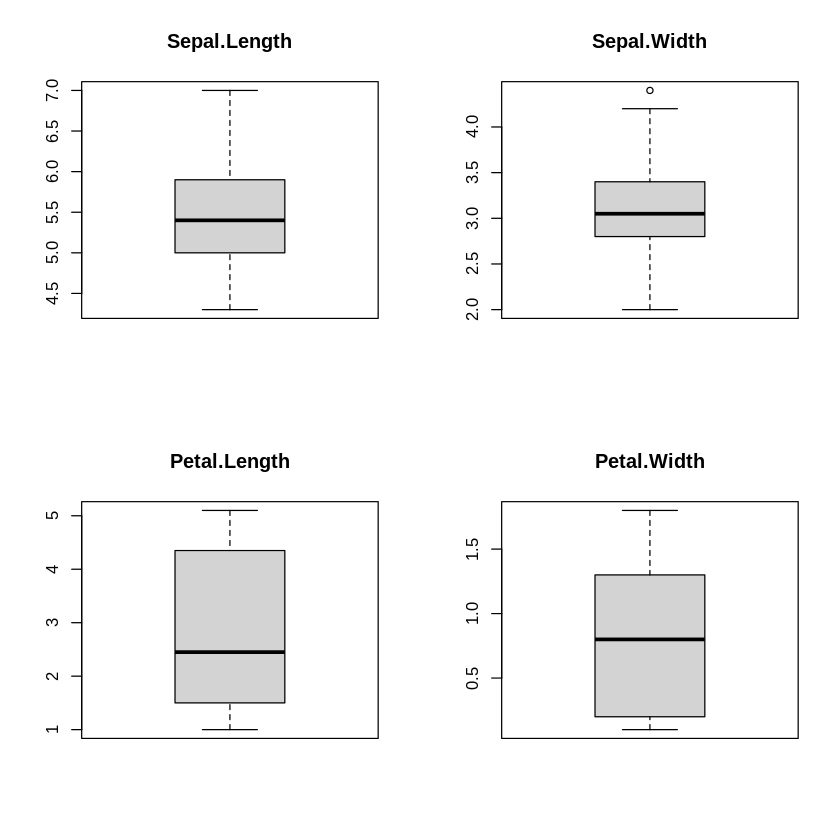

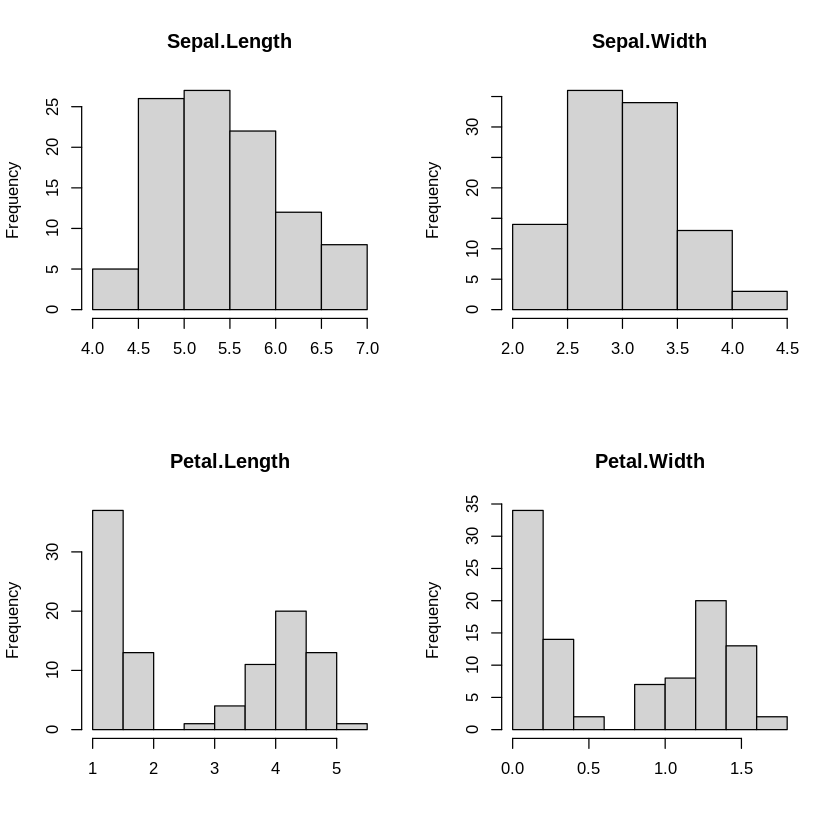

In [ ]:
# Seleccionar solo las variables numéricas
numeric_vars <- wdata[, sapply(wdata, is.numeric)]

# ---------- BOXPLOTS AUTOMÁTICOS ----------
par(mfrow = c(2, ceiling(ncol(numeric_vars)/2)))
for(i in 1:ncol(numeric_vars)){
  boxplot(numeric_vars[, i], main = colnames(numeric_vars)[i])
}

# ---------- HISTOGRAMAS AUTOMÁTICOS ----------
par(mfrow = c(2, ceiling(ncol(numeric_vars)/2)))
for(i in 1:ncol(numeric_vars)){
  hist(numeric_vars[, i], main = colnames(numeric_vars)[i], xlab = "")
}

# Volver a la configuración normal
par(mfrow = c(1,1))


**<u>Interpretación resultados</u>.–**

Los **boxplots** y **histogramas** permiten analizar conjuntamente la **distribución**, **dispersión** y **forma** de las cuatro variables morfológicas del conjunto de datos *iris* tras eliminar la especie *virginica*: *Sepal.Length*, *Sepal.Width*, *Petal.Length* y *Petal.Width*. Este análisis gráfico complementa los estadísticos descriptivos y ayuda a identificar qué variables aportan mayor capacidad discriminante entre las especies *setosa* y *versicolor*.

**Comparación de dispersión y presencia de valores extremos**

A partir de los **boxplots**, se observan diferencias claras entre variables:

- **Sepal.Length** presenta una dispersión moderada, con la mayoría de observaciones concentradas en torno a valores intermedios y sin presencia destacable de valores atípicos. Esto sugiere que el largo del sépalo varía de forma relativamente homogénea entre las dos especies.
- **Sepal.Width** muestra una dispersión algo menor, aunque se detectan algunos valores extremos superiores, lo que indica cierta heterogeneidad en el ancho del sépalo, especialmente en *setosa*.
- **Petal.Length** exhibe una **dispersión considerablemente mayor**, con un rango amplio y cajas más extensas. Esto refleja una clara diferenciación entre especies, ya que *setosa* presenta pétalos notablemente más cortos que *versicolor*.
- **Petal.Width** también presenta una alta dispersión relativa y una separación marcada entre valores bajos y altos, reforzando su papel como variable clave para distinguir entre ambas especies.

**Comparación de la forma de las distribuciones**

Los **histogramas** refuerzan estas conclusiones:

- **Sepal.Length** y **Sepal.Width** presentan distribuciones aproximadamente unimodales y relativamente simétricas, con solapamiento significativo entre especies.
- **Petal.Length** muestra una distribución claramente bimodal, con un grupo concentrado en valores bajos (asociado a *setosa*) y otro en valores más altos (asociado a *versicolor*), evidenciando su alto poder discriminante.
- **Petal.Width** presenta un patrón similar, con fuerte asimetría y concentración de observaciones en dos rangos diferenciados.

**Conclusión**

En conjunto, los gráficos revelan que las **variables del pétalo (longitud y anchura)** presentan **mayor variabilidad y menor solapamiento entre clases**, lo que las convierte en las más informativas para tareas de clasificación entre *setosa* y *versicolor*. Por el contrario, las **variables del sépalo** muestran distribuciones más homogéneas y solapadas, aportando menor capacidad de separación. Este comportamiento justifica que muchos modelos de clasificación sobre el dataset *iris* se apoyen principalmente en las características del pétalo para lograr una buena discriminación entre especies.


Tras el proceso de filtrado del conjunto de datos **iris**, se ha eliminado la especie *virginica*, quedando únicamente **dos clases**: *setosa* y *versicolor*. La base de datos resultante consta de **100 observaciones**, 50 correspondientes a cada especie, lo que garantiza un **perfecto equilibrio entre clases**, una característica especialmente favorable para el entrenamiento y evaluación de modelos de clasificación binaria.

Cada observación está descrita mediante **cuatro variables cuantitativas continuas** que recogen medidas morfológicas de la flor: **longitud y anchura del sépalo** (*Sepal.Length*, *Sepal.Width*) y **longitud y anchura del pétalo** (*Petal.Length*, *Petal.Width*). Estas variables presentan escalas comparables y no contienen valores perdidos, lo que simplifica el preprocesamiento de los datos. Los análisis descriptivos y gráficos previos muestran que, mientras las variables del sépalo presentan un mayor solapamiento entre especies, las variables del pétalo exhiben una separación más clara, lo que anticipa su mayor capacidad discriminante en tareas de clasificación.

Dado que el objetivo es **modelizar y evaluar el rendimiento predictivo** de distintos enfoques de regresión logística, esta base de datos constituye un escenario adecuado: el tamaño muestral es suficiente para aplicar técnicas de remuestreo como **bootstrap** y **validación cruzada**, las clases están balanceadas y las variables explicativas contienen información relevante para distinguir entre las dos especies. En este contexto, se procederá a dividir los datos en conjuntos de entrenamiento y test, entrenar los modelos bajo distintos esquemas de validación y comparar su desempeño mediante métricas estándar de clasificación.


<div style="background-color:#5DADE2"><b>Apartado 2</b></div>

Dividimos el conjunto de datos en entrenamiento (train) y prueba (test) para poder evaluar de forma objetiva la capacidad de generalización del modelo, es decir, su rendimiento sobre datos no vistos durante el entrenamiento.

En concreto:

1. Evitar el sobreajuste (overfitting)
Si el modelo se evalúa sobre los mismos datos con los que se ha ajustado, puede aprender patrones específicos del conjunto de datos (incluido el ruido) y mostrar un rendimiento artificialmente alto. Separar un conjunto de test permite comprobar si el modelo mantiene su capacidad predictiva fuera de la muestra de entrenamiento.

2. Simular el uso real del modelo
En un escenario real, el modelo se aplica a observaciones nuevas. El conjunto de test actúa como una aproximación a este escenario, proporcionando una estimación realista del desempeño esperado en producción.

3. Evaluación imparcial del modelo
El conjunto de test no debe intervenir en ninguna fase del entrenamiento ni de selección de hiperparámetros. De este modo, las métricas calculadas (precisión, AUC-ROC, sensibilidad, especificidad, etc.) son imparciales y comparables entre modelos distintos.

4. Separar ajuste y evaluación
Técnicas como bootstrap o validación cruzada k-fold se aplican exclusivamente sobre el conjunto de entrenamiento para estimar la estabilidad del modelo y optimizarlo. El conjunto de test queda reservado como una evaluación final independiente.

En resumen, la división train–test es esencial para garantizar que las conclusiones extraídas sobre el rendimiento del modelo sean válidas, robustas y extrapolables, y no el resultado de un ajuste excesivo a los datos disponibles.

In [ ]:
install.packages("caret")
library(caret)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice



In [ ]:
# Para reproducibilidad
set.seed(143)

# Dividimos los datos en un conjunto de entrenamiento y otro de prueba para poder evaluar el modelo
index = caret::createDataPartition(wdata$Species , p = 0.8, list = FALSE)

Warning message in caret::createDataPartition(wdata$Species, p = 0.8, list = FALSE):
“Some classes have no records ( virginica ) and these will be ignored”


In [ ]:
# Definimos los conjuntos de entrenamiento y test
train_set = wdata[index, ]
test_set  = wdata[-index, ]

In [ ]:
# Mostramos el conjunto de entrenamiento
head(train_set); nrow(train_set)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa


[1] 80

In [ ]:
# Mostramos el conjunto de test
head(test_set); nrow(test_set)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
16,5.7,4.4,1.5,0.4,setosa
24,5.1,3.3,1.7,0.5,setosa
25,4.8,3.4,1.9,0.2,setosa
32,5.4,3.4,1.5,0.4,setosa


[1] 20

In [ ]:
# Identificamos cuántas observaciones tenemos en cada grupo de pasajeros en el conjunto de train
# Grupo 0: no sobrevivieron; Grupo 1: sobrevivieron
table(train_set$Species ) |> prop.table()


    setosa versicolor  virginica 
       0.5        0.5        0.0 

In [ ]:
# Identificamos cuántas observaciones tenemos en cada grupo de pasajeros en el conjunto de test
table(train_set$Species ) |> prop.table()


    setosa versicolor  virginica 
       0.5        0.5        0.0 

**Interpretación resultados.-** Como se observan estan perfectamente equilibradas

<div style="background-color:#5DADE2"><b>Apartado 3</b></div>

In [ ]:
# Configuramos el control de entrenamiento para usar boosdtrap, lo que ayuda a evitar
# el sobreajuste y proporciona una estimación más robusta del rendimiento del modelo
trainControl = caret::trainControl(method = "boot", number = 10000)

In [ ]:
train_set$Species <- droplevels(train_set$Species)
test_set$Species  <- droplevels(test_set$Species)

modelo_logit_boot <- caret::train(
  Species ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width,
  data = train_set,
  method = "glm",
  family = binomial,
  trControl = trainControl
)

Se han truncado las últimas 5000 líneas del flujo de salida.
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message

In [ ]:
# Visualizamos un resumen del proceso de entrenamiento
print(modelo_logit_boot)

Generalized Linear Model 

80 samples
 4 predictor
 2 classes: 'setosa', 'versicolor' 

No pre-processing
Resampling: Bootstrapped (10000 reps) 
Summary of sample sizes: 80, 80, 80, 80, 80, 80, ... 
Resampling results:

  Accuracy  Kappa
  1         1    



**<u>Interpretación Output 1</u>.-**

El **Output 1** resume el proceso de entrenamiento de un **modelo de Regresión Logística**, formulado como un **Modelo Lineal Generalizado (GLM)**, aplicado a un conjunto de **80 observaciones** con **4 variables predictoras** (*Sepal.Length, Sepal.Width, Petal.Length y Petal.Width*) y **2 clases** (*setosa* y *versicolor*).

El modelo se ha entrenado **sin preprocesamiento previo**, lo que indica que las variables originales se han utilizado directamente, y se ha evaluado mediante la técnica de **bootstrap**, con un número elevado de réplicas (**10.000 remuestreos**). En cada réplica bootstrap, se ha generado una muestra de tamaño 80 (con reemplazamiento) a partir del conjunto de entrenamiento original, ajustando el modelo y evaluando su rendimiento sobre las observaciones no seleccionadas o mediante estimación interna.

Los resultados del remuestreo muestran valores de **Accuracy = 1** y **Kappa = 1**, lo que implica que el modelo clasifica correctamente el **100 % de las observaciones** en todas las réplicas bootstrap. El estadístico **Kappa**, al tomar valor 1, confirma que esta clasificación perfecta no se debe al azar, sino a una concordancia total entre las predicciones del modelo y las clases reales.

Desde un punto de vista estadístico, este resultado indica una **separación prácticamente perfecta entre las clases *setosa* y *versicolor*** en el espacio definido por las variables predictoras, algo coherente con la conocida estructura del conjunto de datos Iris, donde ambas especies son altamente distinguibles.

No obstante, aunque el rendimiento observado es óptimo, debe interpretarse con cautela: resultados perfectos bajo bootstrap pueden indicar que el problema es **intrínsecamente sencillo** o que existe un riesgo potencial de **sobreajuste**, especialmente cuando se trabaja con conjuntos de datos pequeños y altamente separables. Por ello, este resultado debe contrastarse posteriormente con la evaluación en el **conjunto de test independiente**, para confirmar la capacidad real de generalización del modelo.


**<u>Procedimiento de bootstrap para el entrenamiento del modelo</u>.–**

La técnica de **bootstrap** es un método de remuestreo que se utiliza para **estimar la estabilidad y variabilidad de un modelo predictivo** sin necesidad de disponer de nuevos datos. A continuación se describe paso a paso el procedimiento aplicado al entrenamiento de un modelo de **regresión logística**.

**Paso 1. Construcción del conjunto de entrenamiento**  
Partimos del conjunto de datos de entrenamiento, que contiene observaciones etiquetadas en dos clases (*setosa* y *versicolor*). Este conjunto actúa como población empírica a partir de la cual se generarán las muestras bootstrap.

**Paso 2. Generación de muestras bootstrap**  
Se generan **\(B = 1000\)** muestras bootstrap.  
Cada muestra bootstrap se obtiene **muestreando con reemplazamiento** a partir del conjunto de entrenamiento original y tiene **el mismo tamaño** que dicho conjunto.  
Como consecuencia del muestreo con reemplazamiento:
- Algunas observaciones aparecen repetidas.
- Otras no aparecen en la muestra (observaciones *out-of-bag*).

**Paso 3. Ajuste del modelo en cada muestra**  
Para cada una de las 1000 muestras bootstrap:
- Se ajusta un **modelo de regresión logística** usando las variables explicativas (medidas del sépalo y pétalo).
- Se estiman los coeficientes del modelo y las probabilidades de pertenencia a cada clase.

Este proceso genera **1000 modelos ligeramente distintos**, cada uno entrenado sobre una versión diferente del conjunto de datos.

**Paso 4. Evaluación interna del rendimiento**  
En cada iteración, el rendimiento del modelo se evalúa:
- Bien sobre las observaciones *out-of-bag* (no incluidas en la muestra bootstrap),
- O bien mediante una métrica agregada interna definida por el procedimiento de entrenamiento (por ejemplo, accuracy o AUC).

Esto permite obtener una estimación del error de generalización sin utilizar todavía el conjunto de test.

**Paso 5. Agregación de resultados**  
Una vez completadas las 1000 iteraciones:
- Las métricas de rendimiento se **promedian** para obtener una estimación estable del comportamiento del modelo.
- Se obtiene una medida de **variabilidad** (desviación estándar) del rendimiento, lo que informa sobre la **robustez del modelo** frente a pequeñas perturbaciones en los datos.

**Paso 6. Modelo final**  
El modelo reportado corresponde al **promedio del rendimiento** obtenido en las iteraciones bootstrap.  
Este modelo no se evalúa todavía sobre el conjunto de test, que queda reservado para una **evaluación final e imparcial**.




<div style="background-color:#5DADE2"><b>Apartado 4</b></div>

**<u>Procedimiento de la validación cruzada k-fold (k = 10)</u>.–**

La **validación cruzada k-fold** es una técnica de evaluación que permite estimar el **rendimiento de generalización** de un modelo utilizando de forma eficiente todo el conjunto de datos de entrenamiento. A continuación se describe paso a paso el procedimiento para el caso **k = 10**, aplicado al entrenamiento de un modelo de **regresión logística**.

**Paso 1. Definición del conjunto de entrenamiento**  
Se parte del conjunto de datos de entrenamiento, previamente separado del conjunto de test. Este conjunto contiene observaciones etiquetadas en dos clases (*setosa* y *versicolor*), y será el único utilizado durante el proceso de validación cruzada.

**Paso 2. Partición del conjunto en k subconjuntos**  
El conjunto de entrenamiento se divide en **k = 10 subconjuntos disjuntos** (denominados *folds*), aproximadamente del mismo tamaño.  
En un esquema estratificado (habitual en clasificación), cada fold mantiene **proporciones similares de ambas clases**, evitando sesgos debidos al desbalanceo.

**Paso 3. Iteraciones de entrenamiento–validación**  
El procedimiento se repite **10 veces**, una por cada fold:
- En cada iteración, **9 folds** se utilizan como conjunto de entrenamiento.
- El **fold restante** se utiliza como conjunto de validación.

De este modo, cada observación del conjunto de entrenamiento:
- Se usa **una vez para validar** el modelo.
- Se usa **nueve veces para entrenarlo**.

**Paso 4. Ajuste del modelo en cada iteración**  
En cada iteración:
- Se ajusta un **modelo de regresión logística** sobre los 9 folds de entrenamiento.
- Se generan predicciones sobre el fold de validación.
- Se calculan métricas de rendimiento (por ejemplo, accuracy, sensibilidad, especificidad o AUC).

Esto produce **10 estimaciones del rendimiento**, una por cada fold.

**Paso 5. Agregación de resultados**  
Una vez completadas las 10 iteraciones:
- Las métricas obtenidas se **promedian** para obtener una estimación global del rendimiento del modelo.
- También puede calcularse la **variabilidad entre folds**, lo que proporciona información sobre la estabilidad del modelo.

**Paso 6. Selección del modelo final**  
El rendimiento medio obtenido mediante validación cruzada se utiliza para:
- Evaluar la calidad del modelo.
- Comparar distintos modelos o configuraciones (por ejemplo, selección de variables o hiperparámetros).

Tras este proceso, el modelo final se ajusta utilizando **todo el conjunto de entrenamiento**.

**Conclusión**  
La validación cruzada k-fold con \( k = 10 \) ofrece un equilibrio adecuado entre **sesgo y varianza** en la estimación del error, proporcionando una evaluación fiable del modelo sin desperdiciar datos. Es una técnica especialmente adecuada cuando el tamaño muestral es limitado y se desea una estimación robusta del rendimiento antes de evaluar el modelo en el conjunto de test.


In [ ]:
# Configuramos el control de entrenamiento para usar validación cruzada de 10 pliegues, lo que ayuda a evitar
# el sobreajuste y proporciona una estimación más robusta del rendimiento del modelo
trainControl = caret::trainControl(method = "repeatedcv", number = 10, repeats = 10)

In [ ]:
# Entrenamos el modelo utilizando el modelo de árbol de decisión (rpart)
modelo_dt = caret::train(Species ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width,, data = train_set, method = "rpart", trControl = trainControl)

In [ ]:
# Visualizamos un resumen del proceso de entrenamiento
print(modelo_dt)

CART 

80 samples
 4 predictor
 2 classes: 'setosa', 'versicolor' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 72, 72, 72, 72, 72, 72, ... 
Resampling results across tuning parameters:

  cp   Accuracy  Kappa
  0.0  1.0       1    
  0.5  1.0       1    
  1.0  0.5       0    

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.5.


**<u>Interpretación Output 2</u>.-**

El **Output 2** corresponde al entrenamiento de un **modelo CART (Classification And Regression Tree)** aplicado al mismo conjunto de datos, compuesto por **80 observaciones**, **4 variables predictoras** (*Sepal.Length, Sepal.Width, Petal.Length y Petal.Width*) y **2 clases** (*setosa* y *versicolor*).

En este caso, el modelo se ha evaluado mediante **validación cruzada repetida**, concretamente un esquema **10-fold repetido 10 veces**. Esto implica que el conjunto de datos se divide en 10 subconjuntos, utilizando en cada iteración 9 folds (72 observaciones) para entrenamiento y 1 fold para validación, repitiendo todo el proceso 10 veces con distintas particiones. Este procedimiento proporciona una estimación más estable y robusta del rendimiento del modelo frente a la variabilidad muestral.

El parámetro de complejidad **`cp`** controla el tamaño del árbol:  
- Valores pequeños de `cp` permiten árboles más complejos, con mayor número de divisiones.  
- Valores grandes de `cp` fuerzan árboles más simples, con menos nodos.

Los resultados muestran que:
- Para **`cp = 0.0`** y **`cp = 0.5`**, el modelo alcanza **Accuracy = 1** y **Kappa = 1**, lo que indica una clasificación perfecta y una concordancia total entre predicciones y clases reales.
- Para **`cp = 1.0`**, el rendimiento cae drásticamente (**Accuracy = 0.5**, **Kappa = 0**), lo que refleja un modelo excesivamente simplificado, incapaz de capturar la estructura discriminante de los datos.

Dado que la **Accuracy** fue el criterio de selección y que tanto `cp = 0.0` como `cp = 0.5` alcanzan el valor máximo, el algoritmo selecciona como modelo final **`cp = 0.5`**, al representar una solución **más parsimoniosa** que evita complejidad innecesaria sin pérdida de rendimiento.

En conjunto, estos resultados confirman que las especies *setosa* y *versicolor* son **fácilmente separables** mediante reglas de decisión simples basadas en las variables morfológicas, y que un árbol de complejidad moderada es suficiente para lograr una **clasificación perfecta**. Al igual que en el modelo logístico, este desempeño excepcional debe validarse posteriormente en el **conjunto de test**, para asegurar que la capacidad predictiva se mantiene fuera del conjunto de entrenamiento.


<div style="background-color:#5DADE2"><b>Apartado 5</b></div>

**La matriz de confusión**
 La **matriz de confusión** evalua el rendimiento de un modelo de clasificación, ya que compara las **predicciones del modelo** con las **clases reales**. En el caso de un problema binario, la matriz se organiza en torno a dos clases: setosa y versicolor.

- **Verdaderos Negativos (TN)**: corresponden a las observaciones que **realmente pertenecen a la clase 0** y que el modelo **clasifica correctamente como 0**.

- **Falsos Positivos (FP)**: son las observaciones que **realmente pertenecen a la clase 0**, pero que el modelo **clasifica incorrectamente como 1**.

- **Falsos Negativos (FN)**: son las observaciones que **realmente pertenecen a la clase 1**, pero que el modelo **clasifica incorrectamente como 0**.

- **Verdaderos Positivos (TP)**: corresponden a las observaciones que **realmente pertenecen a la clase 1** y que el modelo **clasifica correctamente como 1**.

**Accuracy (Precisión global)**  
La *Accuracy* mide la **proporción total de observaciones correctamente clasificadas** por el modelo. Se calcula como el número de predicciones correctas dividido entre el número total de observaciones. Es una medida global del rendimiento del clasificador y resulta especialmente informativa cuando las clases están **balanceadas**, como ocurre en este conjunto de datos. Sin embargo, puede ser engañosa en problemas con fuerte desbalanceo de clases, ya que un modelo podría obtener una alta accuracy simplemente prediciendo siempre la clase mayoritaria.

**Sensibilidad (Recall o True Positive Rate)**  
La *Sensibilidad* cuantifica la **capacidad del modelo para identificar correctamente los individuos de la clase positiva**. Se define como la proporción de verdaderos positivos sobre el total de observaciones que realmente pertenecen a la clase positiva. Esta métrica es clave cuando el objetivo principal es **detectar correctamente una clase concreta**, minimizando los falsos negativos, por ejemplo en problemas médicos o de detección de fraude.

**Especificidad (True Negative Rate)**  
La *Especificidad* mide la **capacidad del modelo para identificar correctamente los individuos de la clase negativa**. Se calcula como la proporción de verdaderos negativos sobre el total de observaciones que realmente pertenecen a la clase negativa. Es especialmente relevante cuando se desea **evitar falsos positivos**, es decir, cuando clasificar erróneamente un individuo como positivo tiene un coste elevado.

**AUC de la curva ROC**  
El *AUC* (Area Under the Curve) de la **curva ROC** resume en un único valor la **capacidad discriminante del modelo** para distinguir entre las dos clases, considerando todos los posibles umbrales de decisión. Un valor de AUC cercano a 0.5 indica un clasificador sin capacidad discriminante (equivalente al azar), mientras que un valor cercano a 1 indica una separación casi perfecta entre clases. A diferencia de la accuracy, el AUC es **robusto frente al desbalanceo de clases** y proporciona una visión más completa del rendimiento del modelo.


Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor
  setosa         10          0
  versicolor      0         10
                                     
               Accuracy : 1          
                 95% CI : (0.8316, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : 9.537e-07  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : versicolor 
                                     

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor
  setosa         10          0
  versicolor      0         10
                                     
               Accuracy : 1          
                 95% CI : (0.8316, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : 9.537e-07  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : versicolor 
                                     

Accuracy 
       1

Kappa 
    1

Accuracy 
       1

Kappa 
    1

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting direction: controls < cases

Setting direction: controls < cases



Area under the curve: 1

Area under the curve: 1

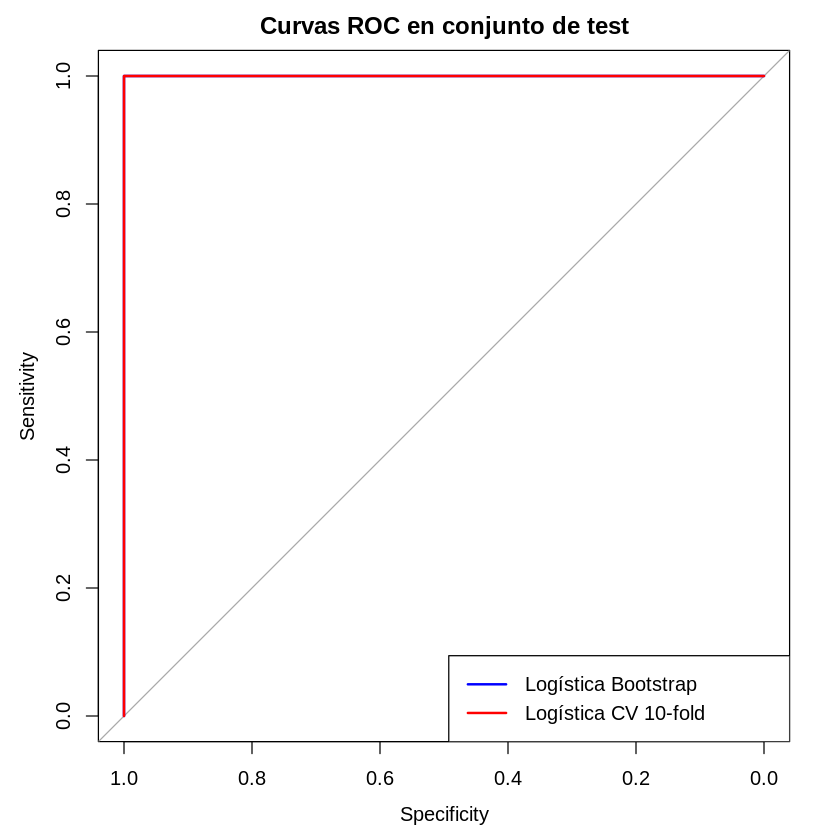

In [ ]:


# Predicciones de clase
pred_boot <- predict(modelo_logit_boot, newdata = test_set)
pred_cv   <- predict(modelo_dt,   newdata = test_set)

# Predicciones de probabilidad (necesarias para ROC y AUC)
prob_boot <- predict(modelo_logit_boot, newdata = test_set, type = "prob")
prob_cv   <- predict(modelo_dt,   newdata = test_set, type = "prob")


# MATRICES DE CONFUSIÓN

cm_boot <- caret::confusionMatrix(pred_boot, test_set$Species, positive = "versicolor")
cm_cv   <- caret::confusionMatrix(pred_cv,   test_set$Species, positive = "versicolor")

cm_boot
cm_cv


# MÉTRICAS PRINCIPALES

accuracy_boot <- cm_boot$overall["Accuracy"]
kappa_boot    <- cm_boot$overall["Kappa"]

accuracy_cv <- cm_cv$overall["Accuracy"]
kappa_cv    <- cm_cv$overall["Kappa"]

accuracy_boot; kappa_boot
accuracy_cv;   kappa_cv

# CURVA ROC Y AUC

library(pROC)

roc_boot <- roc(response = test_set$Species,
                predictor = prob_boot$versicolor,
                levels = c("setosa","versicolor"))

roc_cv <- roc(response = test_set$Species,
              predictor = prob_cv$versicolor,
              levels = c("setosa","versicolor"))

auc_boot <- auc(roc_boot)
auc_cv   <- auc(roc_cv)

auc_boot
auc_cv

#  Comparación gráfica
plot(roc_boot, col = "blue", main = "Curvas ROC en conjunto de test")
lines(roc_cv, col = "red")
legend("bottomright",
       legend = c("Logística Bootstrap", "Logística CV 10-fold"),
       col = c("blue","red"), lwd = 2)


**<u>Interpretación de resultados</u>.-**

Las **matrices de confusión** obtenidas para ambos modelos de regresión logística (entrenado mediante **bootstrap** y mediante **validación cruzada 10-fold**) son **idénticas** y muestran una **clasificación perfecta** en el conjunto de test. En concreto, las 20 observaciones de prueba se clasifican correctamente: 10 correspondientes a la especie *setosa* y 10 a *versicolor*, sin errores de clasificación.

Como consecuencia directa de esta clasificación perfecta, todas las métricas de evaluación alcanzan su valor máximo:
- **Accuracy = 1**: el 100 % de las observaciones del conjunto de prueba han sido correctamente clasificadas.
- **Kappa = 1**: existe un acuerdo perfecto entre las predicciones del modelo y las clases reales, incluso tras corregir por el acuerdo esperado por azar.
- **Sensibilidad = 1**: el modelo identifica correctamente todos los individuos de la clase positiva (*versicolor*).
- **Especificidad = 1**: el modelo clasifica correctamente todos los individuos de la clase negativa (*setosa*).
- **Balanced Accuracy = 1**, lo que confirma que el rendimiento es excelente y equilibrado entre ambas clases.

Asimismo, el **AUC de la curva ROC es igual a 1** para ambos modelos, indicando una **capacidad discriminante perfecta**: el modelo separa completamente las dos especies en el espacio de predictores.

En conclusión, tanto el modelo entrenado con **bootstrap** como el entrenado con **validación cruzada k-fold (k = 10)** presentan un **rendimiento idéntico y óptimo en el conjunto de prueba**. Este resultado es coherente con la naturaleza del problema, ya que las especies *setosa* y *versicolor* del conjunto *iris* son **altamente separables** a partir de las variables morfológicas consideradas. Por tanto, en este caso concreto, la elección entre bootstrap y validación cruzada no afecta al desempeño final, sino que ambos procedimientos confirman la **estabilidad y capacidad de generalización del modelo logístico**.
